<a href="https://colab.research.google.com/github/Boro2001/reinforcement-learning/blob/main/reinforcement-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reinforcement learning with tensorflow
!pip install pettingzoo
from pettingzoo.sisl import pursuit_v4
import tensorflow as tf
import numpy as np
import keras
from collections import deque


TRAIN = False
ENV_NAME = 'Pursuit-v4'

env = pursuit_v4.env(
    max_cycles=500,
    x_size=16,
    y_size=16,
    shared_reward=True,
    n_evaders=30,
    n_pursuers=1,
    obs_range=7,
    n_catch=2,
    freeze_evaders=False,
    tag_reward=0.01,
    catch_reward=5.0,
    urgency_reward=-0.1,
    surround=True,
    constraint_window=1.0,
    # render_mode='human'
    )

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
num_actions = env.action_space(env.possible_agents[0]).n
observation_size = env.observation_space(env.possible_agents[0]).shape

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=observation_size),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(num_actions)
])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.8/826.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 29.7 MB/s eta 0:00:00


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 147)               0         
                                                                 
 dense (Dense)               (None, 32)                4736      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,957
Trainable params: 5,957
Non-trainable params: 0
_________________________________________________________________


In [3]:
env.reset()

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last() ########


    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample()
    env.step(action)
env.close()


In [4]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=1)[0]
        return Q_values.argmax()  # optimal action according to the DQN

from collections import deque
replay_buffer = deque(maxlen=2000)
# extra code – A basic circular buffer implementation
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

def play_one_step(env, state, epsilon, agent_id):
    dead = env.truncations[agent_id] or env.terminations[agent_id]
    if dead:
        next_state, reward, done, truncated, info = env.last()
        action = None
        env.step(action)
        return next_state, reward, done, truncated, info
    else:
        action = epsilon_greedy_policy(state, epsilon)
    #print("action",action)
    #print("truncated: ",env.truncations[agent_id])
    env.step(action)
    #next_state, reward, done, truncated, info = env.last() # TODO: do zmiany (step zmienia agenta)
    
    next_state = env.observe(agent_id)
    reward = env.rewards[agent_id]
    done = env.terminations[agent_id]
    truncated = env.truncations[agent_id]
    info = env.infos[agent_id]

    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, num_actions)
    #print("mask", mask)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

for episode in range(600):
    env.reset()    
    for step in range(200):
        for agid in env.agent_iter():
            obs = env.observe(agid)
            epsilon = max(1 - episode / 500, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon, agid)
            if done or truncated:
                break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

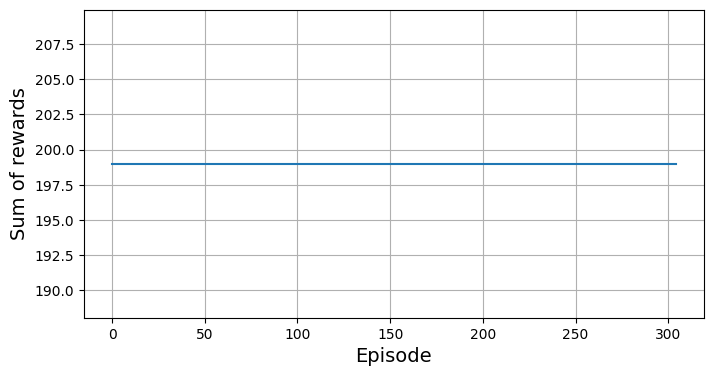

In [ ]:
import matplotlib.pyplot as plt
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
#save_fig("dqn_rewards_plot")
plt.show()

# extra code – shows an animation of the trained DQN playing one episode
#show_one_episode(epsilon_greedy_policy)